---
title: Main - Reporting
subject: Churn Analysis
subtitle: Reporting - Churn Analysis
short_title: Reporting
date: 2025-12-17

affiliations:
  - id: "ucb"
    name: "University of California, Berkeley"

authors:
  - name: Jocelyn Perez
    affiliations: ["ucb"]
    email: jocelyneperez@berkeley.edu
    orcid: 0009-0009-0231-9254

  - name: Claire Kaoru Shimazaki
    affiliations: ["ucb"]
    email: ckshimazaki@berkeley.edu
    orcid: 0009-0001-0828-3370

  - name: Colby Zhang
    affiliations: ["ucb"]
    email: colbyzhang@berkeley.edu
    orcid: 0009-0005-4786-6922

  - name: Olorundamilola Kazeem
    affiliations: ["ucb"]
    email: dami@berkeley.edu
    orcid: 0000-0003-2118-2221

# https://mystmd.org/guide/frontmatter#frontmatter-downloads
# https://mystmd.org/guide/website-downloads
# downloads:
#   -  ...

# https://mystmd.org/guide/website-downloads#include-exported-pdf
# exports:
#   - format: pdf
#     template: lapreprint-typst
#     output: exports/my-document.pdf
#     id: my-document-export
# downloads:
#   - id: my-document-export
#     title: A PDF of this document

exports:
  - format: pdf
    template: lapreprint-typst
    output: ../pdf_builds/main/main_ipynb_to.pdf
    line_numbers: true

license: CC-BY-4.0

keywords: main, churn, reprting, spotify

abstract: Reporting...
---


# Main: Reporting

In [1]:
import src.step00_utils as step00_utils


In [9]:
import pandas as pd
from pathlib import Path
from IPython.display import Image, display



# Predicting User Churn from Listening Behavior

## Introduction
User churn is a critical challenge for subscription-based platforms such as Spotify, where long-term success depends on sustained user engagement. Understanding which behavioral patterns and user characteristics are associated with churn can help platforms identify at-risk users and design more effective retention strategies.
In this project, we analyze a synthetic Spotify churn dataset to answer the following questions:
What behavioral and demographic factors are associated with user churn?
How well can churn be predicted using machine learning models?
Which features most strongly drive churn predictions, and how do they influence model decisions?
Our analysis follows a structured, reproducible workflow, progressing from data understanding and exploratory analysis to feature engineering, modeling, and interpretability.

## Data Description and Assumptions
The dataset consists of 8,000 synthetic Spotify users generated using GPT to simulate realistic listening behavior, subscription types, device usage, and churn outcomes. Below we list the features of the dataset. 
1. `user_id (Numeric, UUID)`: User's universal unique indentifer: 123 (from 1 to 8000).

2. `gender (Categorical, String)`: User's gender, options are: Male / Female / Other. Example: Female.

3. `age (Numeric, Integer)`: User's age in ### format. Example: 54.

4. `country (Categorical, String)`: User's location in @@ format. Example: US.

5. `subscription_type (Categorical, String)`: User's subscription type, options are Family / Free / Premium / Student. Example: Free.

6. `listening_type (Numeric, Integer)`: User's listening time in minutes per day in #### format. Example: 789.

7. `songs_played_per_day (Numeric, Integer)`: User's number of songs played per day in ### format. Exmaple: 19.

8. `skip_rate (Numeric, Float)`: User's percetange of songs played per day in #.## format. Example: 0.04.

9. `device_type (Categorical, String)`: User's device type, optiona are Desktop / Mobile / Web. Example: Mobile. 

10. `ads_listened_per_week (Numeric, Integer)`: User's number of ads heard per week in ### format. Example: 31.

11. `offline_listening (Numeric, Boolean)`: User's offline usage mode. Example: 0 = Not Active Offline, 1 Active Offline.

12. `is_chruned (Numeric, Boolean)`: User's churn status. The target variable. Example: 0 = Active, 1 = Churned


The target variable is a binary indicator of whether a user churned.
Because the dataset is synthetically generated rather than collected from real users, this analysis should be interpreted as exploratory rather than causal. We assume that the simulated relationships reasonably approximate real-world churn behavior, but we cannot verify the underlying data-generating process. As a result, all findings describe associations and predictive patterns, not causal effects.

Below is a preview of the first few rows of our dataset to illustrate its structure. It was sourced from Kaggle, [linked here](https://www.kaggle.com/datasets/nabihazahid/spotify-dataset-for-churn-analysis)

In [10]:
raw_dir = Path.cwd().parent / "data" / "00_raw"
csv_path = next(raw_dir.glob("*.csv")) 

df = pd.read_csv(csv_path)
print("Loaded:", csv_path.name)

df.head()

Loaded: spotify_churn_dataset.csv


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


## Exploratory Data Analysis 
We conduct exploratory data analysis to understand patterns associated with user churn and to motivate feature selection for downstream modeling.

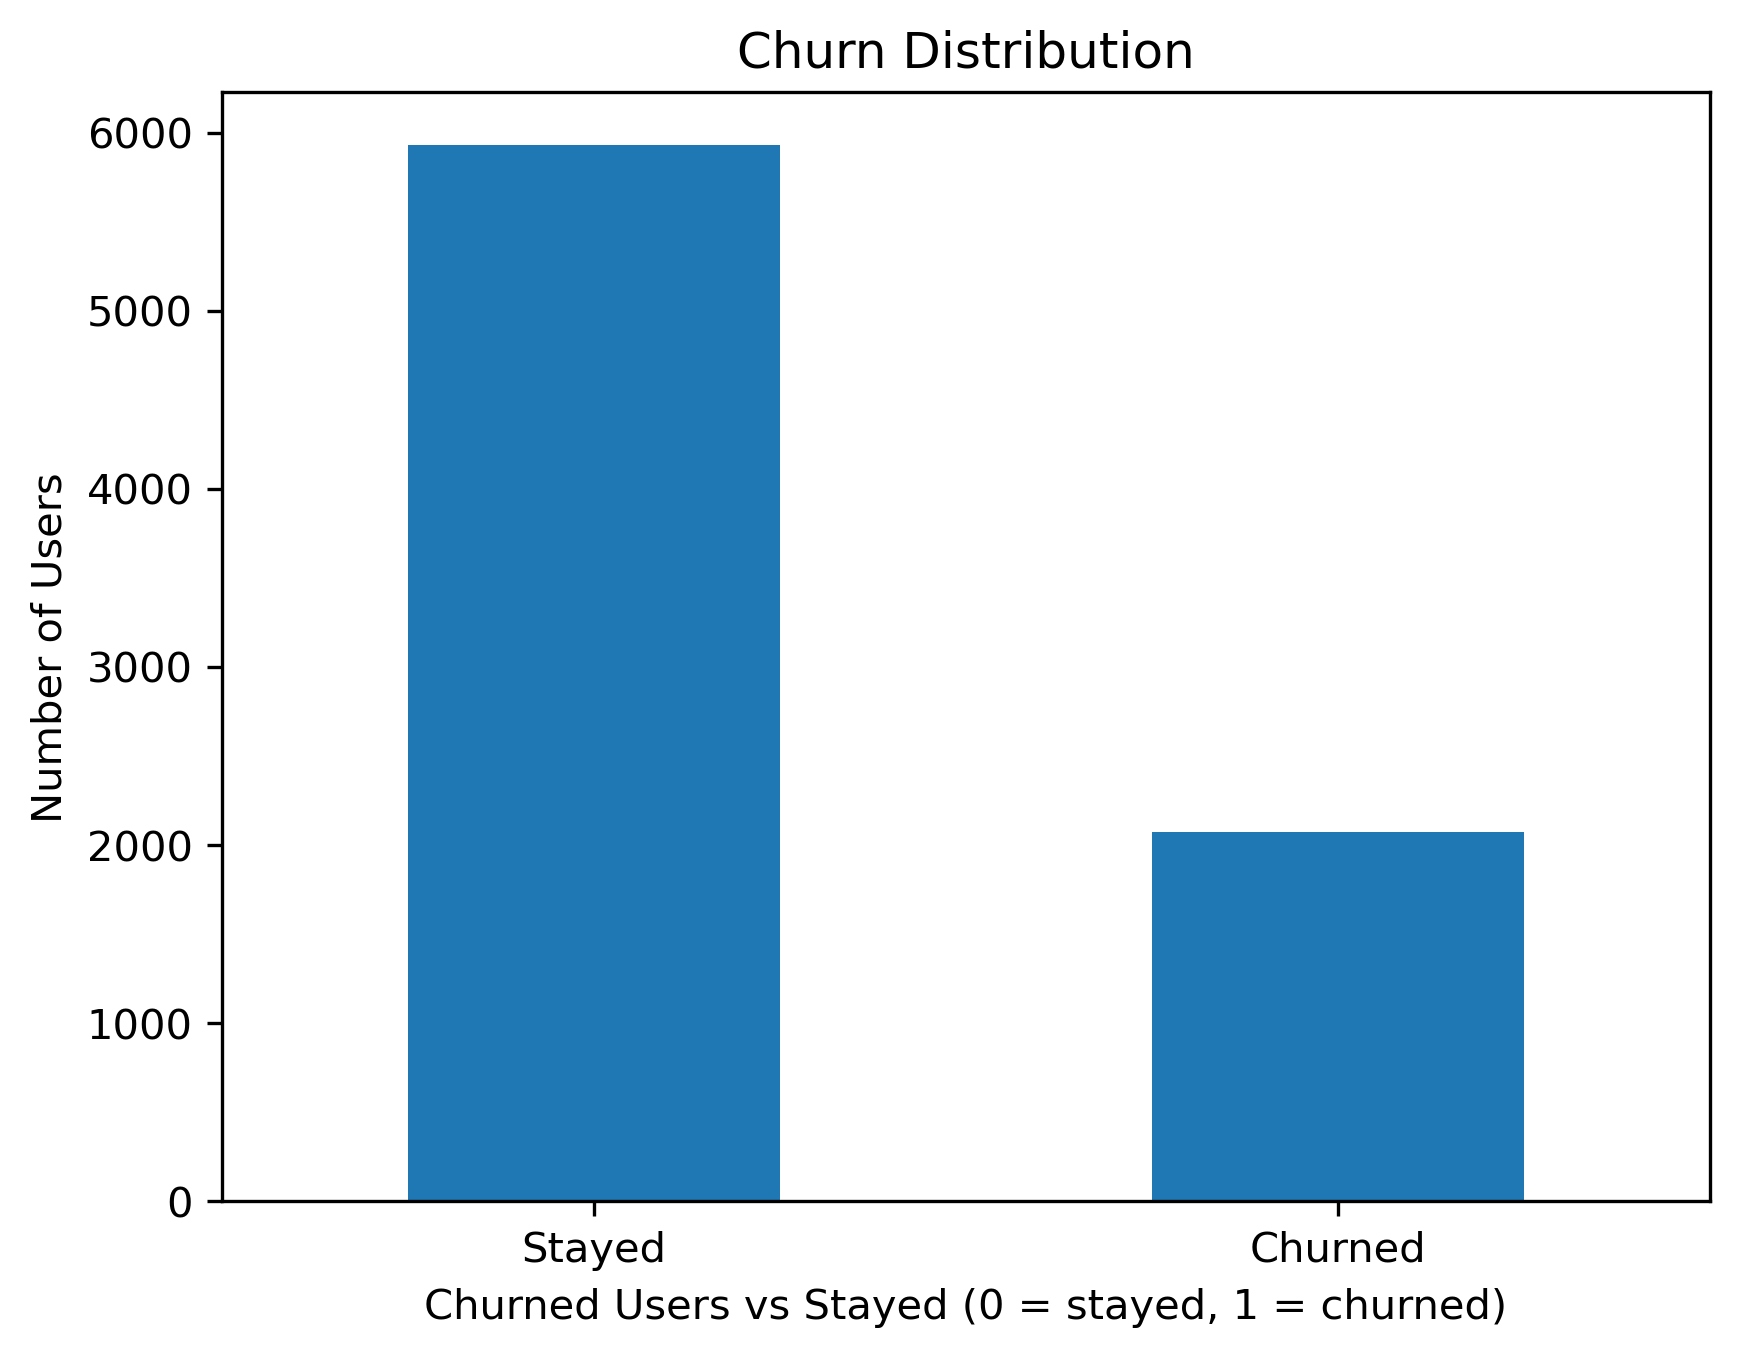

In [11]:
img_path = Path.cwd().parent / "fig_builds" / "step02_eda" / "churn_distribution.png"
display(Image(filename=str(img_path)))

In this first plot, we see that approximately 74% of users did not churn, while 26% churned, which indicates a moderate class imbalance typical of churn prediction problems. This imbalance motivates the use of appropriate evaluation metrics and careful interpretation of model performance.

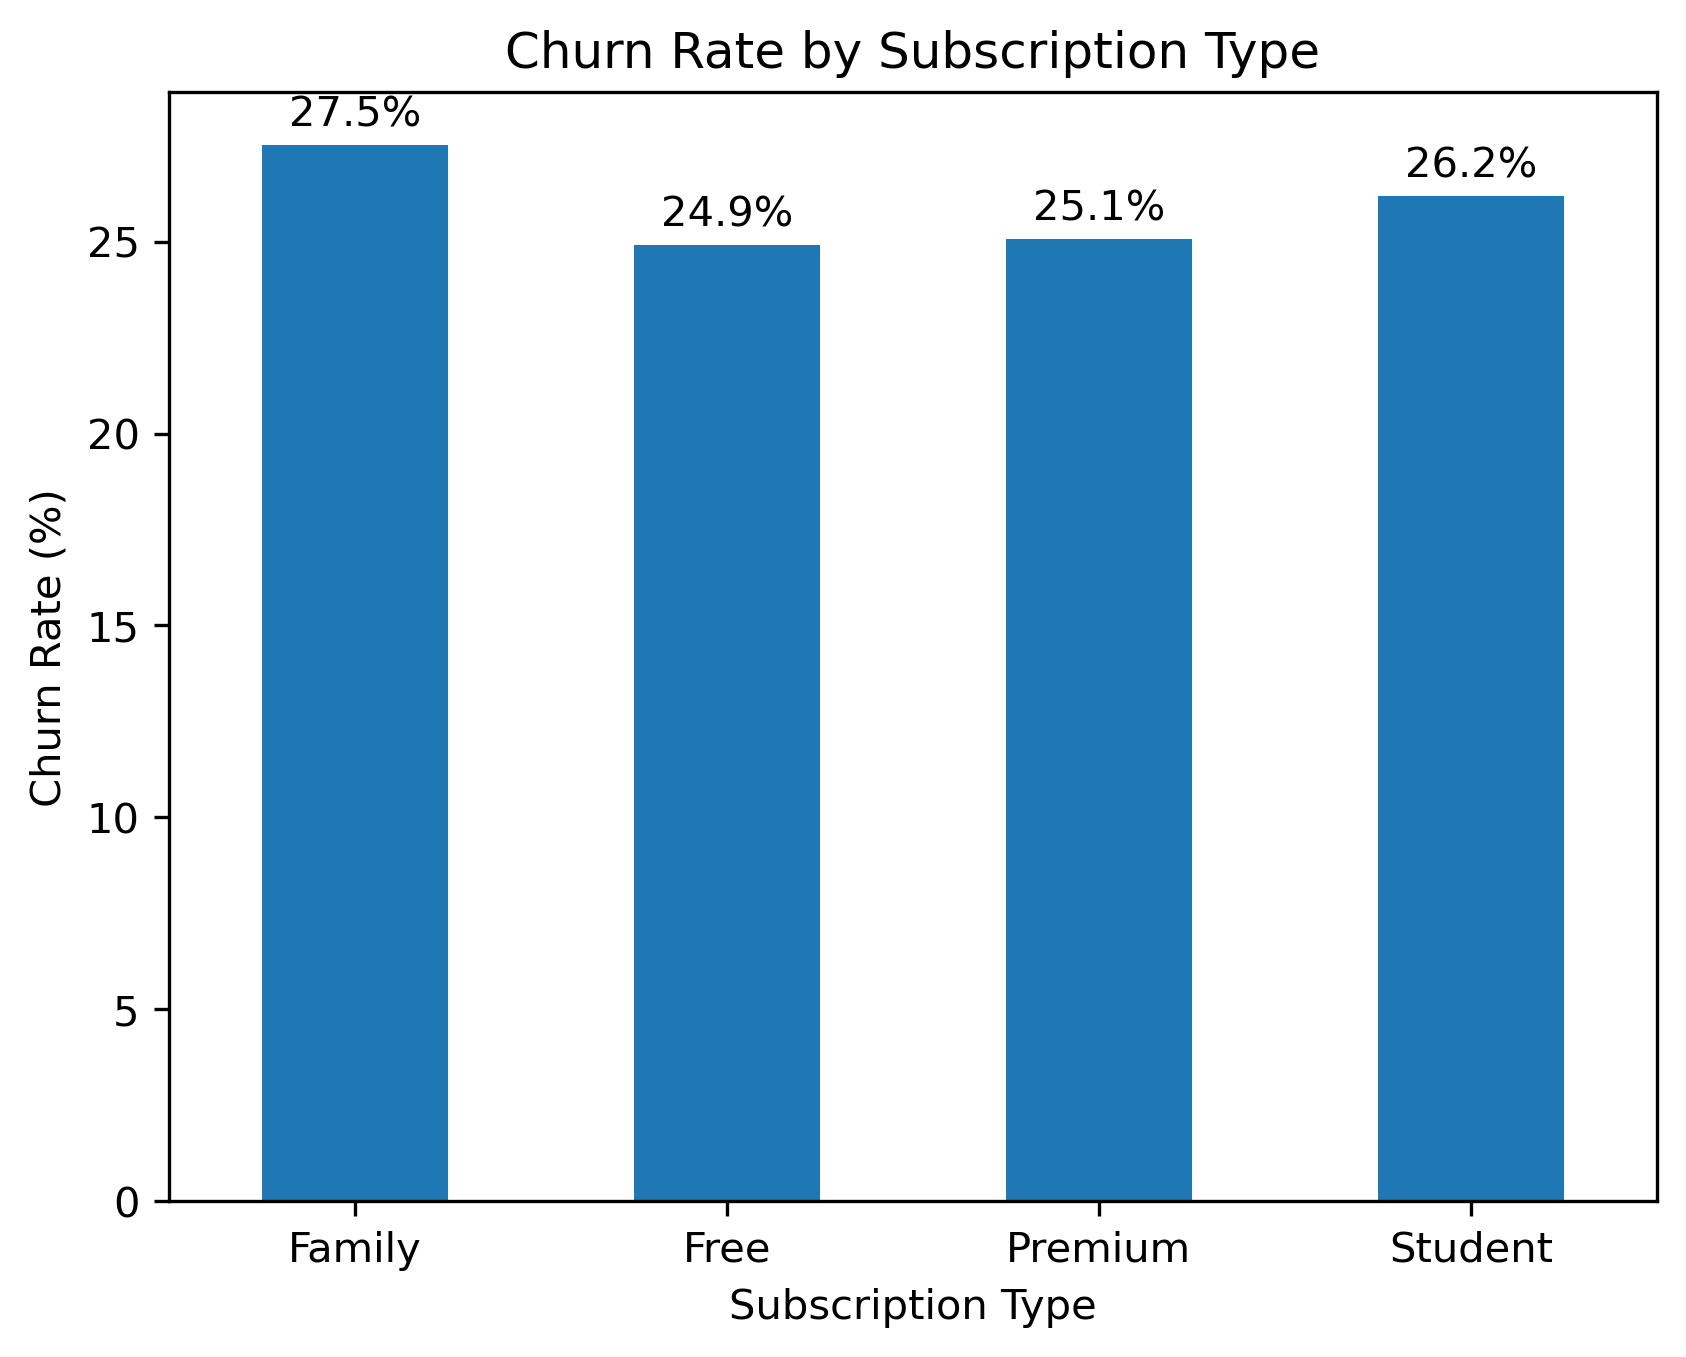

In [13]:
img_path_two = Path.cwd().parent / "fig_builds" / "step02_eda" / "churn_rate_by_subscription_type.png"
display(Image(filename=str(img_path_two)))

Here, we see that among all subscription types, the Family plan exhibits the highest churn rate at approximately 27%, indicating that users on family subscriptions are more likely to churn compared to users on other plans in this dataset.

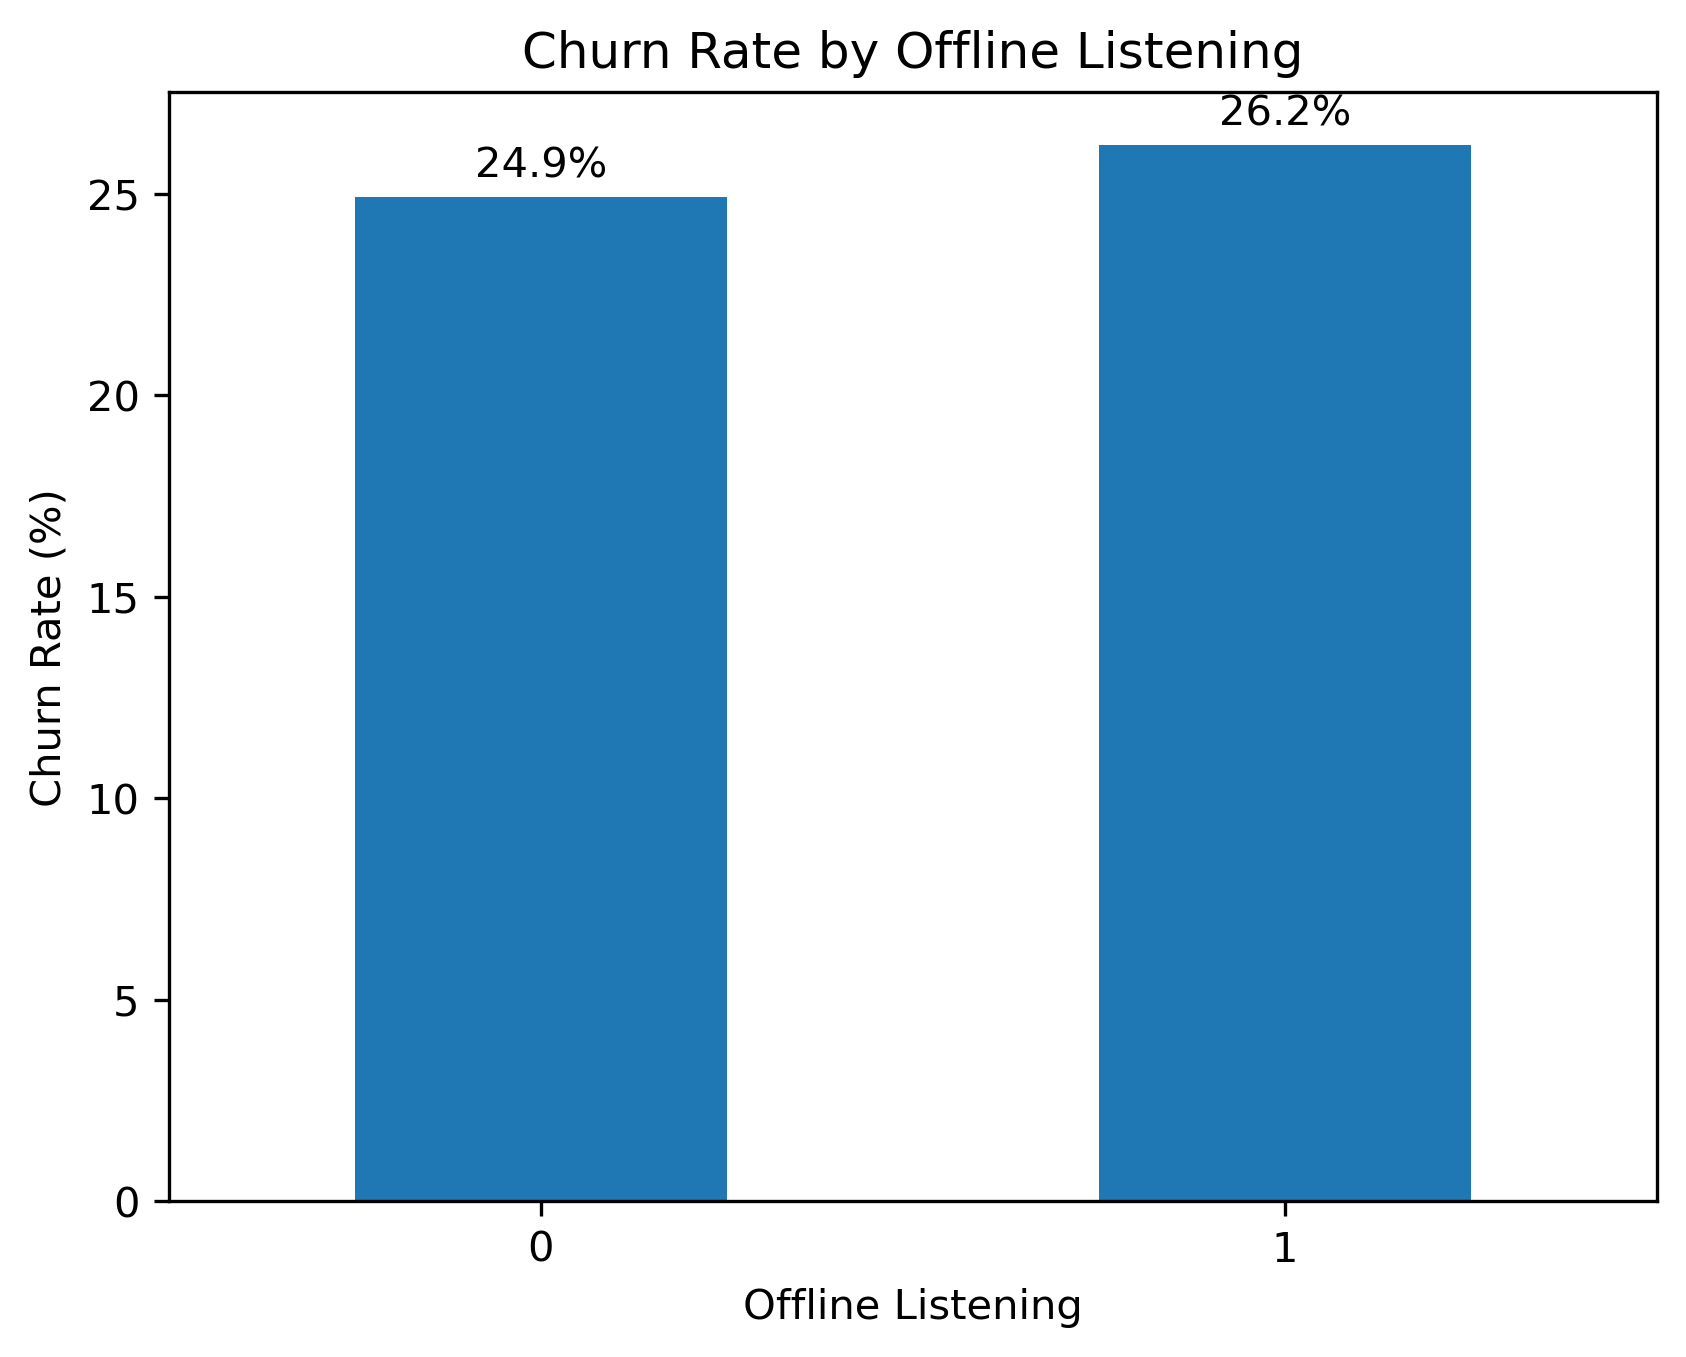

In [14]:
img_path_th = Path.cwd().parent / "fig_builds" / "step02_eda" / "churn_rate_by_offline_listening.png"
display(Image(filename=str(img_path_th)))

Here, we see that users who utilize offline listening features exhibit substantially lower churn rates compared to users who do not. This suggests that offline listening may reflect higher platform dependence and stronger user engagement.

Overall, the EDA showed that churn is more strongly associated with behavioral engagement and subscription characteristics than it is with static demographic features. 

## Feature Engineering and Preprocessing
We create additional features to better capture user engagement and ad exposure, which are likely related to churn. In particular, we engineer avg_song_length to reflect listening depth and ads_per_song (a "frustration metric) to measure ad exposure relative to usage. These features help summarize user behavior in a more interpretable way.
To ensure fair evaluation given the class imbalance, we split the data into 80% training and 20% testing using a stratified split that preserves the churn rate. We then preprocess the data using a scikit-learn pipeline: numeric features are imputed and standardized, categorical features are one-hot encoded, and binary features are passed through unchanged. This results in a processed feature matrix that is used consistently across all downstream models.

## Model Building and Evaluation
We first establish a baseline using Logistic Regression with class weighting to account for imbalance. While interpretable, this linear model achieves limited performance, which shows the complexity of churn behavior.
We then train a Random Forest classifier to model non-linear relationships and feature interactions. Hyperparameters are tuned using cross-validation with F1-score as the primary metric. The Random Forest outperforms the baseline model, which confirms that churn depends on interacting behavioral factors rather than simple linear effects.
However, despite the improved performance, recall for churned users remains low. Many churners are misclassified as retained users, which shows the inherent difficulty of predicting churn and the presence of unobserved factors beyond behavioral data.

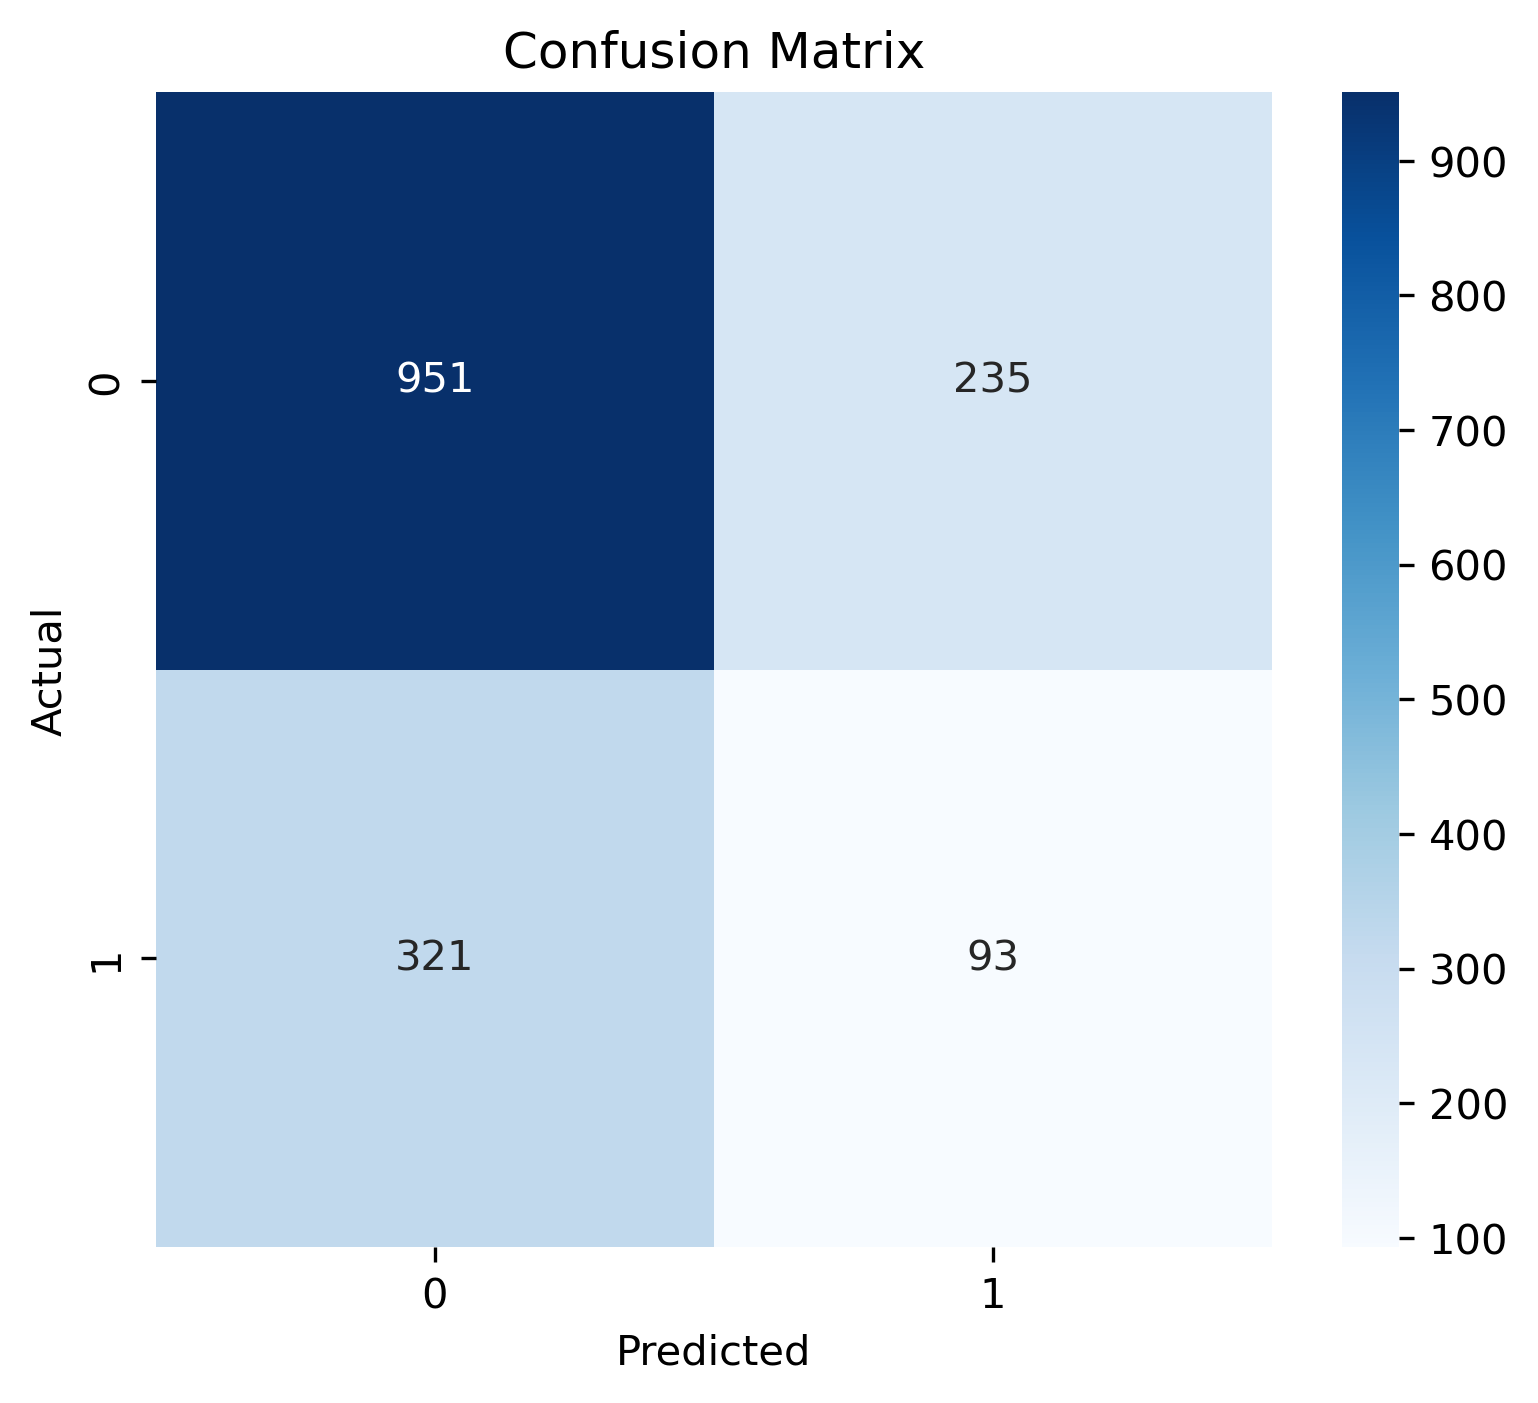

In [20]:
img_path4 = Path.cwd().parent / "fig_builds" / "step04_modeling" / "step04_confusion_matrix.png"
display(Image(filename=str(img_path4)))

In the confusion matrix for the random forest, the model correctly predicts most non-churned users but misses many churned users, showing that accuracy alone is not sufficient under class imbalance.

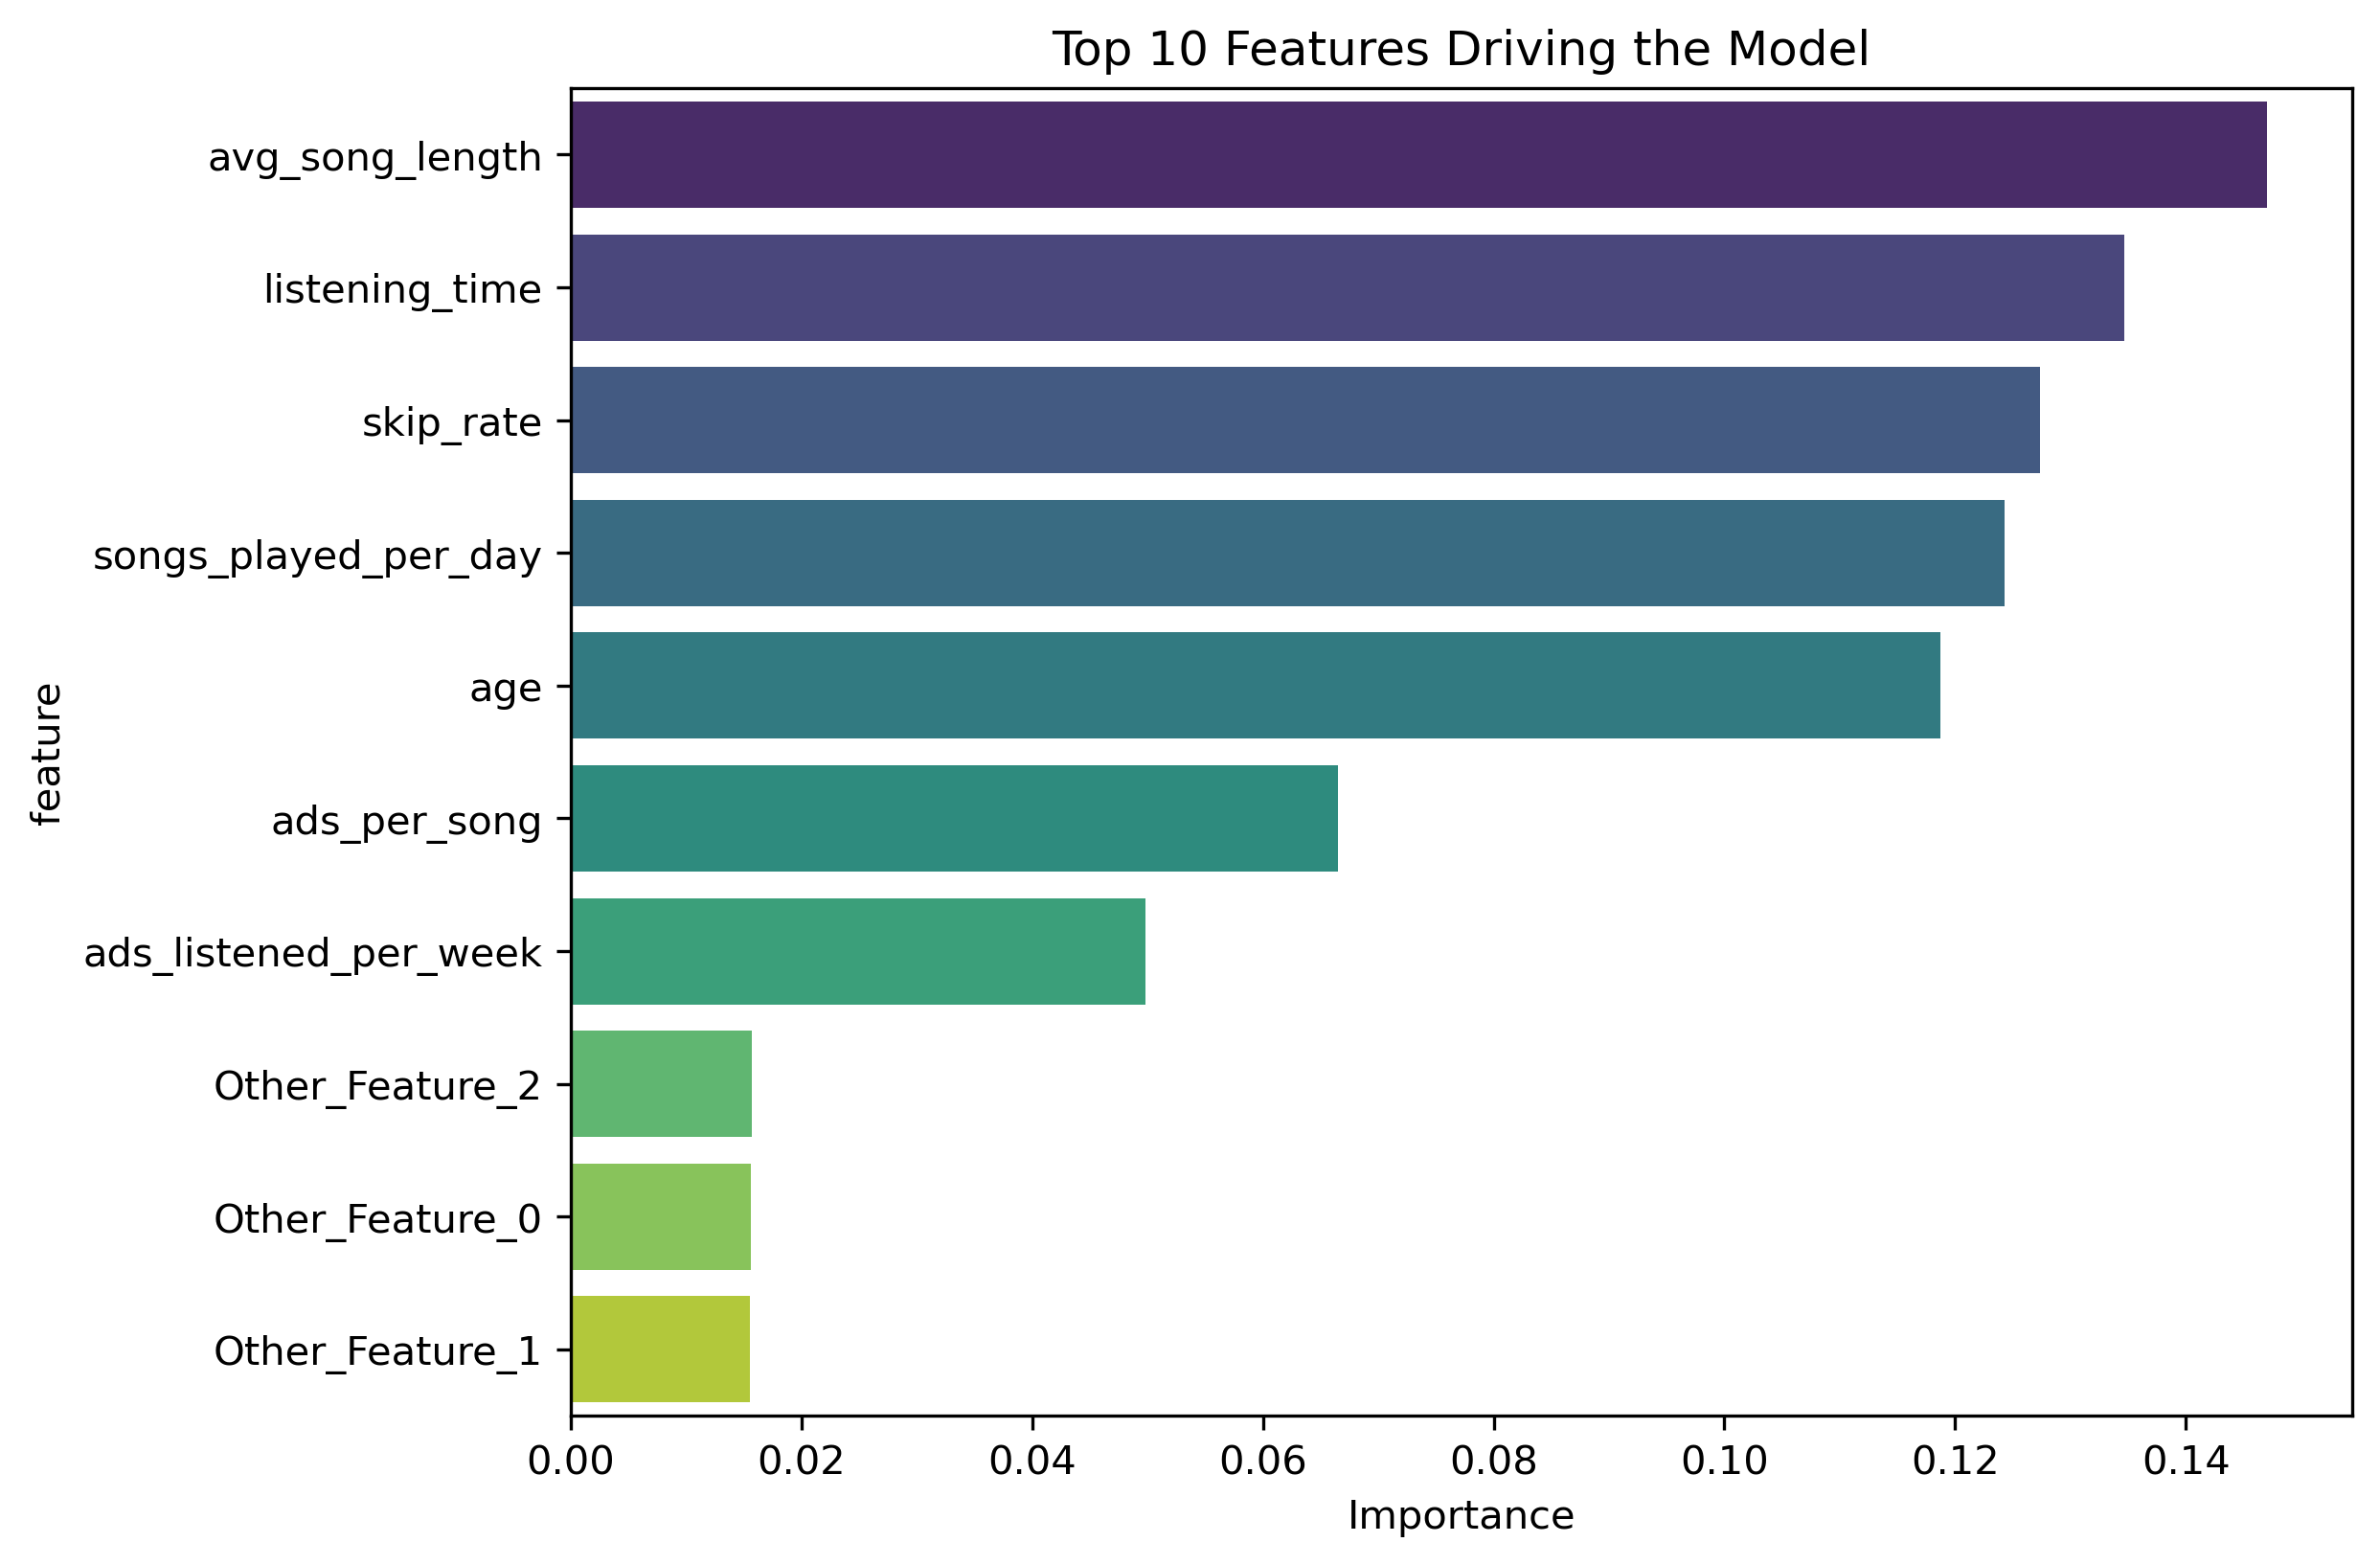

In [22]:
img_path5 = Path.cwd().parent / "fig_builds" / "step04_modeling" / "step04_feature_importance.png"
display(Image(filename=str(img_path5)))

Behavioral engagement features such as average song length, listening time, and skip rate are most important for the model. Again, this shows that usage patterns are stronger predictors of churn than demographic attributes.

## Results and Interpretation
To understand why the Random Forest makes its predictions, we apply model interpretability techniques.
We analyze model outputs to understand what drives churn predictions. Global SHAP results show that engagement-related features such as average song length, listening time, skip rate, and songs played per day are the strongest drivers of churn, while demographic and device features have much less influence. Local SHAP explanations suggest that churn predictions usually come from the combined effect of several small engagement signals, rather than one dominant factor. Partial dependence analysis shows that churn risk drops quickly as engagement increases at low levels and then levels off, indicating that early declines in engagement are especially important.

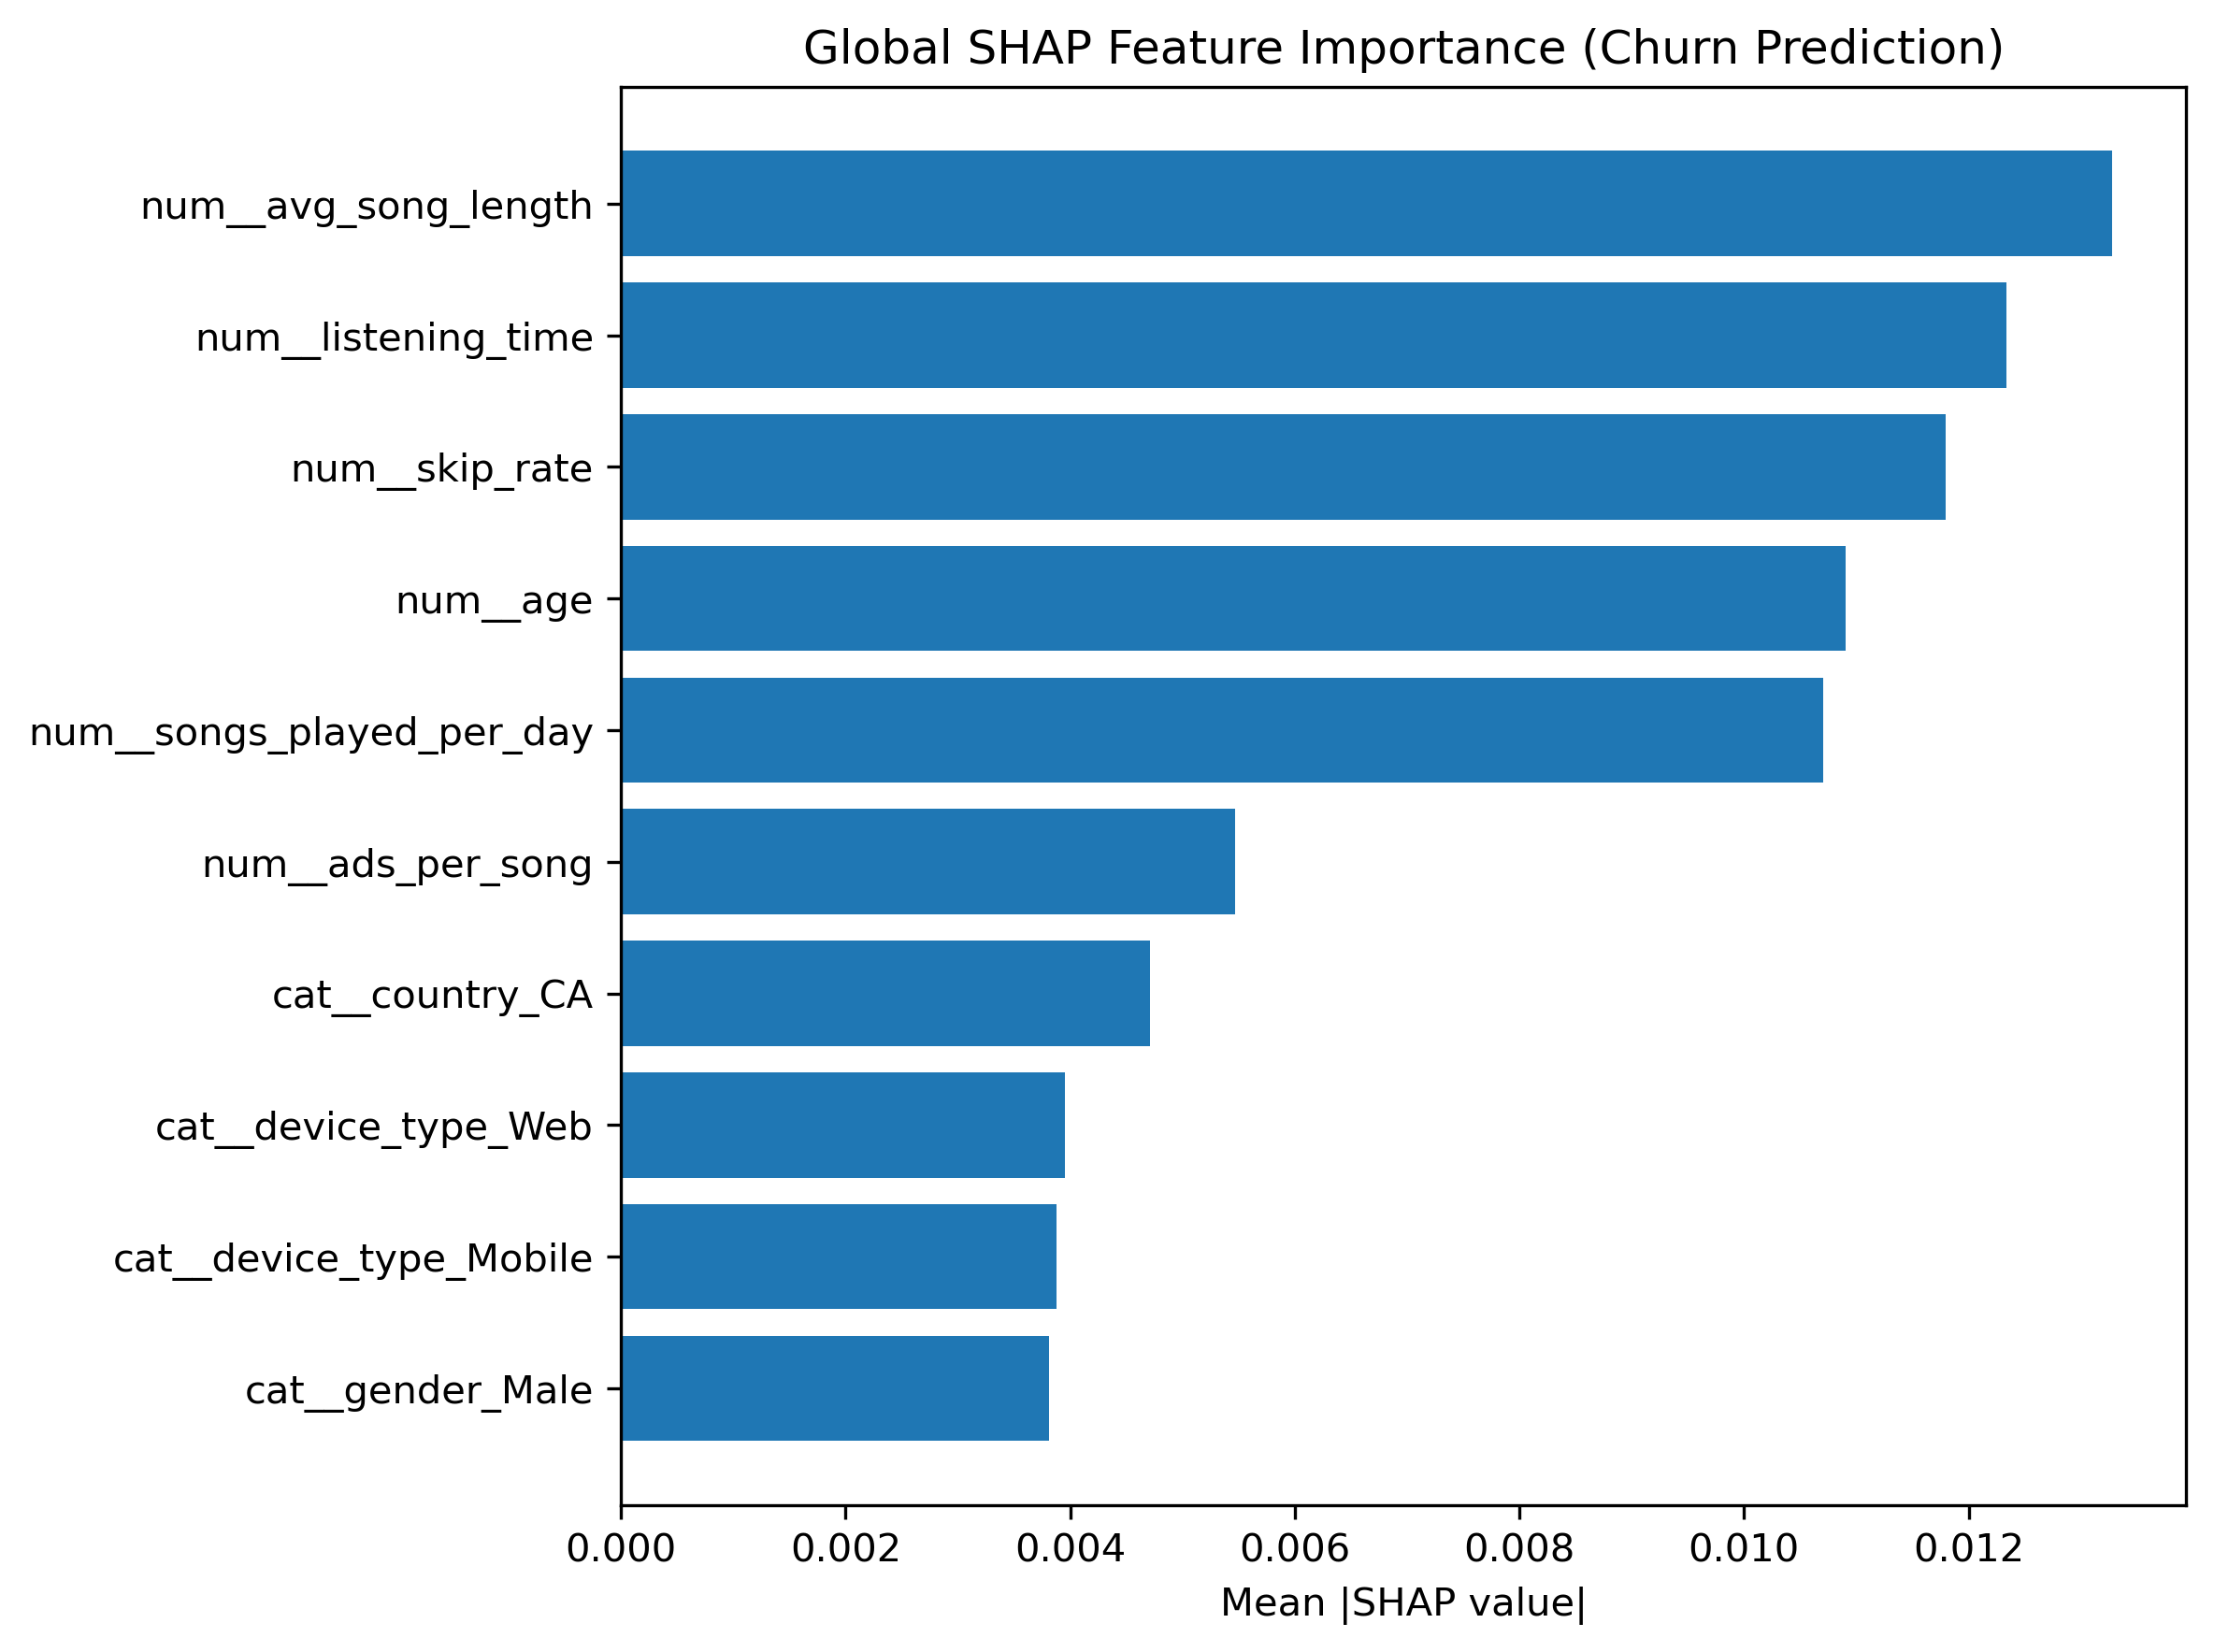

In [25]:
img_path5 = Path.cwd().parent / "fig_builds" / "step05_interpret" / "global_shap_importance.png"
display(Image(filename=str(img_path5)))

Churn predictions are primarily driven by engagement-related features such as average song length, listening time, and skip rate, while demographic and device features play a smaller role.

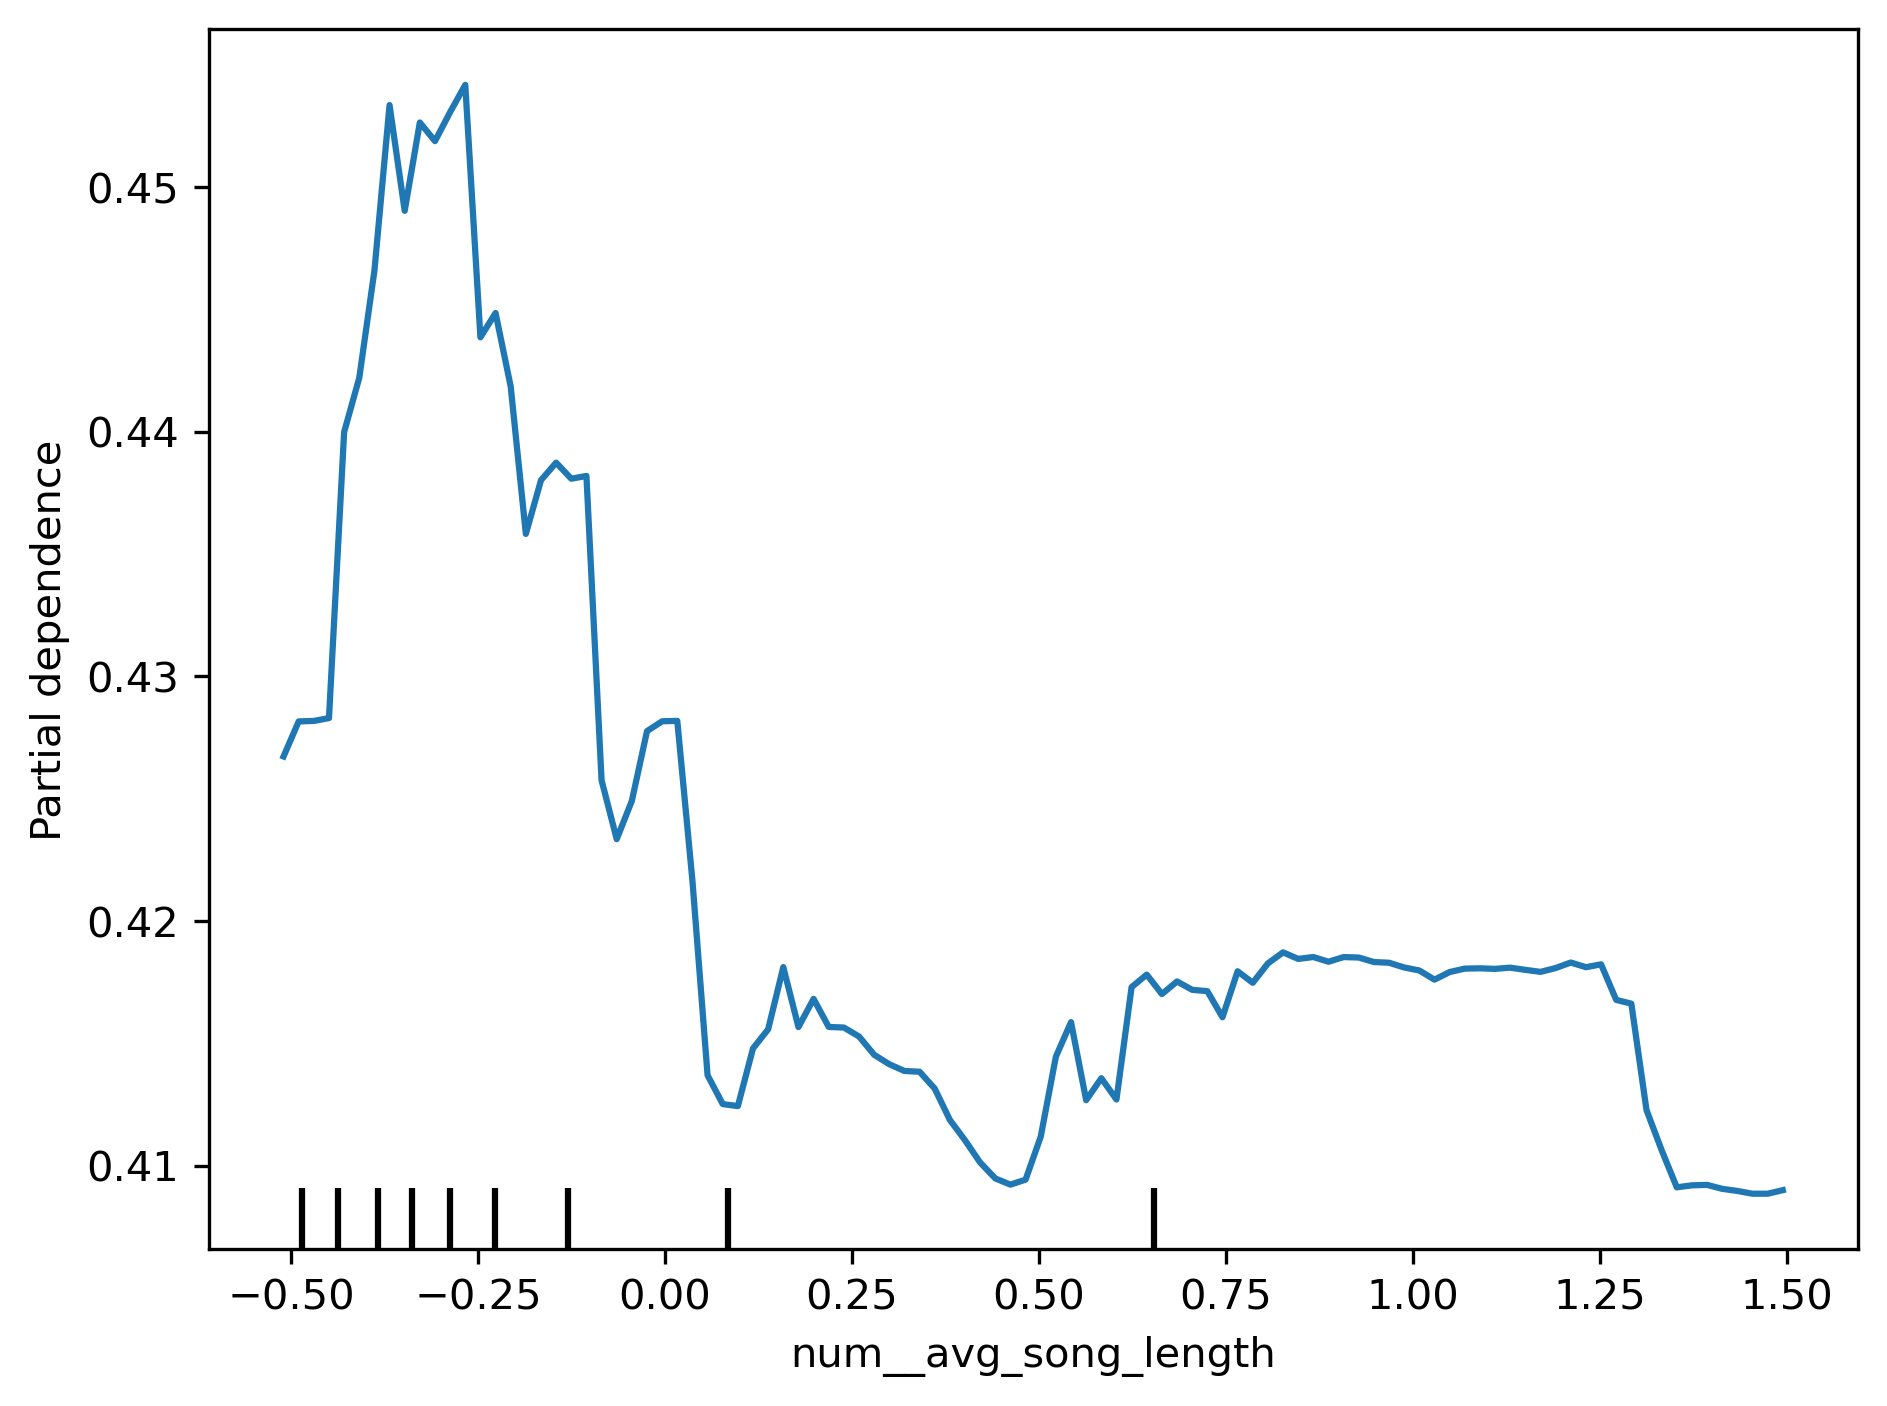

In [24]:
img_path6 = Path.cwd().parent / "fig_builds" / "step05_interpret" / "pdp_num_avg_song_length.png"
display(Image(filename=str(img_path6)))

Users with very short average song lengths have higher predicted churn risk, while users who listen to longer songs on average are less likely to churn.

Overall, churn is more closely related to how users engage with the platform than to who they are. The model’s low recall suggests that many churn decisions are influenced by external or unobserved factors not captured in the data.

## Limitations and Conclusion
This analysis is subject to several limitations. First, the dataset is synthetic and observational, limiting external validity and precluding causal interpretation. Second, behavioral data alone cannot capture all drivers of churn, placing an upper bound on predictive performance. Finally, class imbalance and overlapping feature distributions make churn inherently difficult to predict.



## Author Contributions